In [1]:
import os
import os.path
import glob
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
import sklearn_evaluation.plot as skplot
from sklearn import svm

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Pastel1'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'paper-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from paper-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(9700, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5 # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    y_train = y[train_indices]
    X_test = resnet50features[test_indices]
    y_test = y[test_indices]
    
    top_model = svm.SVC(C=10.0,gamma=0.001)
    start = time.time()
    top_model.fit(X_train,y_train)  # Training
    end = time.time()
    y_pred = top_model.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.9402 (167.7625 s)
[1] Test acurracy: 0.9345 (163.6814 s)
[2] Test acurracy: 0.9490 (166.1522 s)
[3] Test acurracy: 0.9340 (167.5028 s)
[4] Test acurracy: 0.9448 (168.4292 s)


In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9405


Plotting the confusion matrix


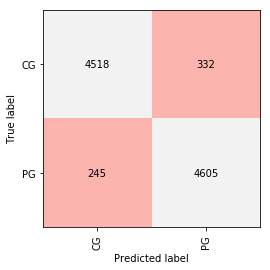

In [29]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
#plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('SVM-ConfusionMatrix_5fold_CV.pdf', format='pdf')
plt.show()

Plotting the confusion matrix normalized


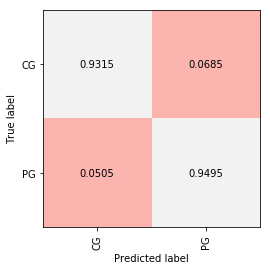

In [30]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=4)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.imshow(conf_mat_norm,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
#plt.title('Confusion matrix normalized')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('SVM-ConfusionMatrixNormalized_5fold_CV.pdf', format='pdf')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(resnet50features,y,test_size=0.2,stratify=y,random_state=1)
top_model = svm.SVC(C=10.0,gamma=0.001,probability=True)
top_model.fit(X_train,y_train)  # Training
y_pred = top_model.predict(X_test)  # Testing
y_score = top_model.predict_proba(X_test)
y_true = y_test

In [15]:
print("Test acurracy: %.4f" %(accuracy_score(y_true,y_pred)))

Test acurracy: 0.9448


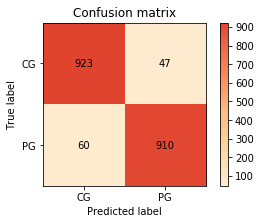

In [16]:
skplot.confusion_matrix(y_true, y_pred,target_names=list_fams)
figure = plt.gcf()
figure.set_size_inches(5, 3)
plt.show()

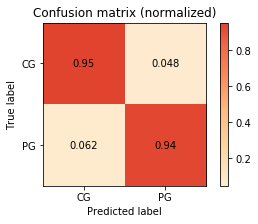

In [17]:
skplot.confusion_matrix(y_true, y_pred,target_names=list_fams,normalize=True)
figure = plt.gcf()
figure.set_size_inches(5, 3)
plt.show()

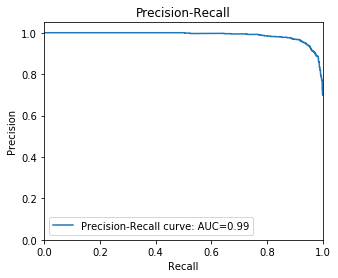

In [31]:
skplot.precision_recall(y_true, y_score)
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.savefig('SVM-PrecisionRecall_AUC.pdf', format='pdf')
plt.show()

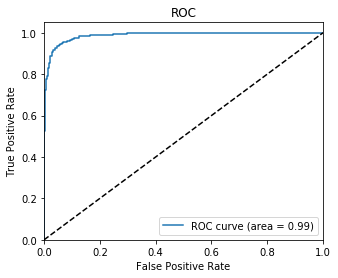

In [32]:
skplot.roc(y_true, y_score)
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.savefig('SVM-ROCcurve_AUC.pdf', format='pdf')
plt.show()

In [20]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
top_model = svm.SVC(C=10.0,gamma=0.001)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(top_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

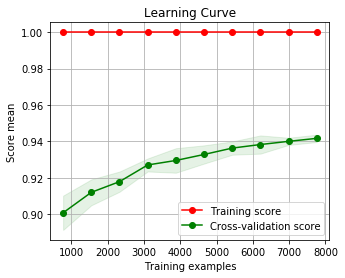

In [33]:
figure = plt.gcf()
figure.set_size_inches(5, 4)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.savefig('SVM-learningcurve.pdf', format='pdf')
plt.show()